<a href="https://colab.research.google.com/github/conner-fransoo/plasma-centrifuge/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plasma centrifuge model

From [_Wijnakker, M. M. B., & Amsterdam Univ. (Netherlands). (1980). Centrifugal effects in a weakly ionized rotating gas_](https://inis.iaea.org/records/ymfdn-qv182)

$$
\sigma_\perp \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial \Phi}{\partial r} \right) + \sigma \frac{\partial^2 \Phi}{\partial z^2} - \sigma_\perp B_0 \frac{1}{r} \frac{\partial}{\partial r}(r v_\theta) = 0
$$

$$
\mu \left(\frac{\partial}{\partial r} (\frac{1}{r} \frac{\partial}{\partial r} (r v_\theta)) + \frac{\partial^2 v_\theta}{\partial z^2}\right) - \sigma_\perp B_0 \left(-\frac{\partial \Phi}{\partial r} + v_\theta B_0 =0 \right)
$$

In [ ]:
import dolfinx, ufl, mpi4py, petsc4py, basix
from dolfinx_external_operator import (FEMExternalOperator, replace_external_operators,
                                       evaluate_operands,evaluate_external_operators)
from dolfinx.fem.petsc import NonlinearProblem, assemble_vector, apply_lifting, set_bc, assemble_matrix
from dolfinx.nls.petsc import NewtonSolver
from dolfinx import fem, mesh
from dolfinx.mesh import locate_entities_boundary, meshtags
from dolfinx import nls, log
from dolfinx.fem import functionspace, Function, locate_dofs_topological, dirichletbc, Constant, form
import ufl.algorithms
from ufl import TestFunctions, TrialFunction, grad, dot, inner, dx, ds, FacetNormal
from basix.ufl import element
from mpi4py import MPI
from petsc4py import PETSc
import scipy.constants as const
from itertools import product
import numpy as np
from scipy.interpolate import RectBivariateSpline

Running installation script...
Sucessfully installed dolfinx version 0.9.0
Installing dolfinx-external-operator...
  Running command git clone --filter=blob:none --quiet https://github.com/a-latyshev/dolfinx-external-operator.git /tmp/pip-req-build-o164v_5_
Importing remaining modules...
Done!


Let's start by defining the variables we'll need for the problem.

In [ ]:
R_0 = 0.115
R1 = R_0 * 0.07
c = 0.3
c_0 = c * 0.66
I = 100  # total current
B0 = 0.5  # magnetic field
voltage = 58.0  # V
a0 = const.physical_constants["Bohr radius"][0]
ion_mass=1.67e-27

In [ ]:
class PlasmaProperties:
    # Assumes n_tot is a constant for now
    def __init__(self, B, Ei, g, m_i, n_tot, alpha, **kwargs):

        self.B = B
        self.Ei = Ei * const.e # Convert eV to Joules
        self.g = g
        self.m_i = m_i
        self.n_tot = n_tot
        self.alpha = alpha

        # Store fundamental constants
        self.e = const.e
        self.k = const.k
        self.m_e = const.m_e
        self.h = const.h
        self.epsilon_0 = const.epsilon_0

        # Minimum ionization fraction constant
        self.min_frac = 0.0

        # Initialize interpolator attribute
        self.iz_interp = None

        iz_file_path = kwargs.get('iz_lookup_table')
        if iz_file_path:
            try:
                data = np.loadtxt(iz_file_path, comments='#', delimiter=',')
                densities, temps, vals = data[1:, 0], data[0, 1:], data[1:, 1:]
                self.iz_interp = RectBivariateSpline(densities, temps, vals)
            except Exception as e:
                print(f"Warning: Failed to load ionization table: {e}")

    def f(self, T_e):
        # Ionization fraction. If an ionization lookup table is provided, use
        # that. Otherwise, fall back to the Saha ionization equation.
        if self.iz_interp is not None:
            x = self.iz_interp(self.n_tot, T_e, grid=False)
        else:
            lambda_th_3 = (self.h / np.sqrt(2 * np.pi * self.m_e * self.k * T_e))**3
            A = 2 / (lambda_th_3 * self.n_tot) * self.g * np.exp(-self.Ei / (const.k * T_e))
            x = 0.5 * (np.sqrt(A**2 + 4 * A) - A)
        #print("ionization frac: " + str(self.min_frac + (1 - self.min_frac) * x))
        return self.min_frac + (1 - self.min_frac) * x

    def ni(self, T_e):
        # Number density of ions
        return self.f(T_e) * self.n_tot

    def ne(self, T_e):
        # Number density of electrons (quasineutrality)
        return self.ni(T_e)

    def omega_i(self):
        # Ion gyrofrequency
        return (self.e * self.B) / self.m_i

    def omega_e(self):
        # Electron gyrofrequency
        return (self.e * self.B) / self.m_e

    def lambda_D(self, T_e):
        # Debye length
        n_e = self.ne(T_e)
        debye_length = np.sqrt((self.epsilon_0 * self.k * T_e) / (n_e * self.e**2))
        return debye_length

    def coulomb_parameter(self, T_e):
        # Coulomb parameter
        n_e = self.ne(T_e)
        lambda_D = self.lambda_D(T_e)
        return 12 * np.pi * n_e * lambda_D**3

    def sigma_spitzer(self, T_e):
        # Spitzer conductivity
        ln_Lambda = np.log(self.coulomb_parameter(T_e))
        numerator = 4 * np.sqrt(2) / 3 * self.e**2 * np.sqrt(self.m_e) * ln_Lambda
        denominator = (4 * np.pi * self.epsilon_0)**2 * (self.k * T_e)**(1.5)
        return 1 / (numerator / denominator)

    def nu_ei(self, T_e):
        # Electron-ion collision frequency
        n_e = self.ne(T_e)
        conductivity = self.sigma_spitzer(T_e)
        return n_e * self.e**2 / (self.m_e * conductivity)

    def nu_en(self, T_e):
        """Electron-neutral collision frequency"""
        v_th_e = np.sqrt(3 * self.k * T_e / self.m_e)

        # Approximation of electron-neutral cross section
        Q_en = 5e-19  # m^2
        nn = (1 - self.f(T_e)) * self.n_tot
        return nn * v_th_e * Q_en

    def nu_in(self, T_h):
        # Ion-neutral collision frequency
        nn = (1 - self.f(T_h)) * self.n_tot
        v_th = np.sqrt(3 * self.k * T_h / self.m_i)
        return nn * v_th * self.Qin_Langevin(T_h)

    def beta_e(self, T_e):
        # Electron Hall parameter
        #print("omega_e: " + str(self.omega_e()))
        #print("nu_ei: " + str(self.nu_ei(T_e)))
        return self.omega_e() / self.nu_ei(T_e)

    def beta_i(self, T_h):
        # Ion Hall parameter
        return self.omega_i() / self.nu_in(T_h)

    def s(self, T_e, T_h):
        # Ion slip factor
        n_i = self.ne(T_e)
        return ((1 - self.f(T_e))**2) * self.beta_e(T_e) * self.beta_i(T_h)

    def beta_eff(self, T_e, T_h):
        # Effective Hall parameter
        s = self.s(T_e, T_h)
        #print("S: " + str(s))
        beta_e = self.beta_e(T_e)
        #print("beta_e: " + str(beta_e))
        numerator = s * (1 + s) + beta_e**2
        #print("numerator: " + str(numerator))
        denominator = 1 + s
        #print("denominator: " + str(denominator))
        return np.sqrt(numerator / denominator)

    def sigma_perp(self, T_e, T_h):
        # Perpendicular (Pedersen) conductivity
        return self.sigma_spitzer(T_e) / (1 + self.beta_eff(T_e, T_h)**2)

    def eta_perp(self, T_e, T_h):
        # Perpendicular (Pedersen) resistivity (defined for external operator usage)
        return 1 / self.sigma_perp(T_e, T_h)

    def sigma_H(self, T_e, T_h):
        # Hall conductivity
        beta_e = self.beta_e(T_e)
        return beta_e * self.sigma_spitzer(T_e) / ((1 + self.s(T_e, T_h))**2 + beta_e**2)

    def Qin_Langevin(self, T_h):
        # Ion-neutral cross section approximation using Langevin polarization scattering.
        # Depends on species polarizability, alpha. Useful when data is not readily available.
        v_th = np.sqrt(3 * self.k * T_h / self.m_i)  # Thermal velocity
        factor = np.sqrt(np.pi * self.alpha * self.e**2 / (self.epsilon_0 * self.m_i))
        return factor / v_th

    def mu_h(self, T_h):
        # Viscosity fit for hydrogen
        return -8.22278*10**(-6) + 5.03195*10**(-7) * T_h**0.58505

    def mu_h_prime(self, T_h):
        # Viscosity fit for hydrogen
        return 2.94394*10**(-7) / (T_h**0.41495)

    def kappa_h(self, T_h):
        # Thermal conductivity fit for hydrogen
        return -0.475048 + 0.0191871 * T_h**0.569845

    def kappa_e(self, T_e):
        """Braginskii equation for electron thermal conductivity perpendicular to B-field"""
        x = self.omega_e() / self.nu_ei(T_e)

        # Coefficients
        gamma0p, gamma1p = 11.92, 4.664
        delta0, delta1 = 3.7703, 14.79

        term1 = self.ne(T_e) * self.k**2 * T_e / (self.m_e * self.nu_ei(T_e))
        term2 = (gamma1p * x**2 + gamma0p) / (x**4 + delta1 * x**2 + delta0)
        return term1 * term2

    def conductivity_ratio(self, T_e, T_h):
        return self.sigma_spitzer(T_e) / self.sigma_perp(T_e, T_h)


# Plasma property object
plasma = PlasmaProperties(B=B0, Ei=13.6, g=0.5, m_i=ion_mass, n_tot=1e21, alpha=4.5*a0**3)

te = 11000
th = 5000

kappa = plasma.kappa_e(te)
print("Electron Thermal Conductivity: " + str(kappa))

sigma = plasma.sigma_spitzer(te)
print("Parallel Conductivity: " + str(sigma))

sigma_perp = plasma.sigma_perp(te, th)
print("Perpendicular Conductivity: " + str(sigma_perp))

viscosity = plasma.mu_h(th)
print("Viscosity: " + str(viscosity))

nu_ei = plasma.nu_ei(te)
print("Electron-ion collision frequency: " + str(nu_ei))

nu_en = plasma.nu_en(te)
print("Electron-neutral collision frequency: " + str(nu_en))

nu_in = plasma.nu_in(th)
print("Ion-neutral collision frequency: " + str(nu_in))

ne = plasma.ne(te)
print("Number density of electrons: " + str(ne))

s = plasma.s(te, th)
print("Ion slip factor: " + str(s))

Electron Thermal Conductivity: 0.006948970289875335
Parallel Conductivity: 2520.7996822677815
Perpendicular Conductivity: 80.8945990276198
Viscosity: 6.519795336058903e-05
Electron-ion collision frequency: 7828769941.652261
Electron-neutral collision frequency: 105967720.23702078
Ion-neutral collision frequency: 1906797.3342794369
Number density of electrons: 7.003257178852343e+20
Ion slip factor: 25.37793080844117


We now create a mesh, a functionspace and a `Function` (containing two subfunctions) for potential $\Phi$ and azimuthal velocity $v_\theta$. We also create test functions for the variational problem.

In [ ]:
mesh = dolfinx.mesh.create_rectangle(
    MPI.COMM_WORLD, [np.array([0.0, 0.0]), np.array([c, R_0])], [150, 200]
)

V = functionspace(mesh, element("Lagrange", mesh.topology.cell_name(), 1, shape=(2,)))

u = Function(V)
phi, v_theta = ufl.split(u)
phi_v, v_theta_test = TestFunctions(V)

We need to create some facet meshtags to be able to apply the boundary conditions later.

In [ ]:
tdim = mesh.topology.dim
facets_top = locate_entities_boundary(mesh, tdim - 1, lambda x: np.isclose(x[1], R_0))
facets_left = locate_entities_boundary(mesh, tdim - 1, lambda x: np.isclose(x[0], 0))
facets_bot = locate_entities_boundary(mesh, tdim - 1, lambda x: np.isclose(x[1], 0))
facets_near_cathode = locate_entities_boundary(
    mesh,
    tdim - 1,
    lambda x: np.logical_and(np.isclose(x[1], R1, rtol=0.2), np.isclose(x[0], 0)),
)
facets_near_anode = locate_entities_boundary(
    mesh,
    tdim - 1,
    lambda x: np.logical_and(np.isclose(x[1], R_0, rtol=0.2), np.isclose(x[0], c_0)),
)

dofs_near_cathode = locate_dofs_topological(V.sub(0), tdim - 1, facets_near_cathode)
dofs_near_anode = locate_dofs_topological(V.sub(0), tdim - 1, facets_near_anode)
dofs_left = locate_dofs_topological(V.sub(1), tdim - 1, facets_left)
dofs_top = locate_dofs_topological(V.sub(1), tdim - 1, facets_top)
dofs_bot = locate_dofs_topological(V.sub(1), tdim - 1, facets_bot)

# create facet markers
facet_indices, facet_markers = [], []
for marker, facets in zip([1, 2], [facets_top, facets_left]):
    for facet in facets:
        facet_indices.append(facet)
        facet_markers.append(marker)

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
fdim = mesh.topology.dim - 1

facet_tag = meshtags(
    mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets]
)

The current flux (Neumann) boundary conditions are imposed using a delta function:

In [ ]:
def delta_function(x, a, mod=np):
    return mod.exp(-((x / a) ** 2)) / (a * mod.sqrt(mod.pi))


a_param = 1 / 400


def flux_left(r, mod=np):
    return -I * delta_function(r - R1, a=a_param, mod=mod) / (2 * mod.pi * R_0)


def flux_top(z, mod=np):
    return +I * delta_function(z - c_0, a=a_param, mod=mod) / (2 * mod.pi * R_0)

This is what the flux distributions look like.

> Note:
> Depending on the refinement of the mesh, these delta functions may not look so smooth

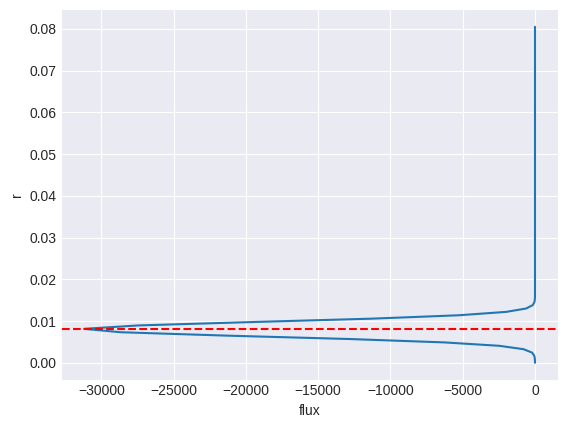

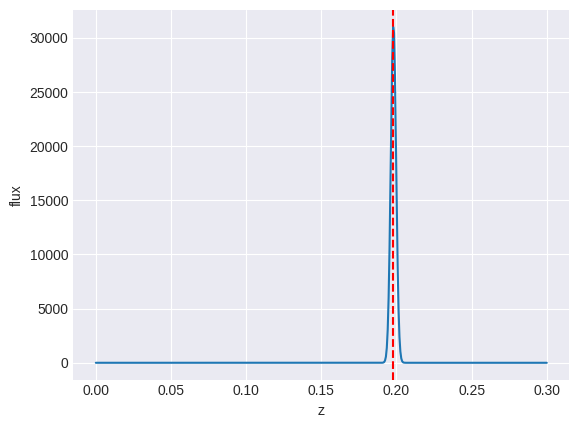

In [ ]:
import matplotlib.pyplot as plt

r_values = np.linspace(0, R1 * 10, 100)
z_values = np.linspace(0, c, 500)

plt.plot(flux_left(r_values), r_values, label="flux_left")
plt.axhline(R1, color="red", linestyle="--")
plt.ylabel("r")
plt.xlabel("flux")
plt.show()

plt.plot(z_values, flux_top(z_values), label="flux_top")
plt.axvline(c_0, color="red", linestyle="--")
plt.ylabel("flux")
plt.xlabel("z")
plt.show()

Now we can write the variational formulation

In [ ]:
# variational formulation
ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag)
dx = ufl.Measure("dx", domain=mesh)

F = 0
x = ufl.SpatialCoordinate(mesh)
z, r = x[0], x[1]

r_safe = r+1e-8 # can add a small parameter to reduce risk of 1/0 errors in 1/r terms

B = -193.33 * (0.25*(0.3-z)**4 - 0.5*(0.184**2)*((0.3-z)**2)) + 0.4985   # curve fit for calculated magnetic field values in CHARYBDIS, assumes z=0.0m is the cathode and z=0.3m is the midplane

# potential
sigma_tensor = ufl.as_tensor([[sigma, 0], [0, sigma_perp]])

F += -1 * inner(sigma_tensor * grad(phi), grad(phi_v)) * r_safe * dx
F += -1 * sigma_perp * B * (r_safe * v_theta).dx(1) * phi_v * dx

# add fluxes
F += flux_left(r=r, mod=ufl) * phi_v * r_safe * ds(2)
F += flux_top(z=z, mod=ufl) * phi_v * r_safe * ds(1)


# velocity
F += viscosity * (dot(grad(v_theta), grad(v_theta_test * r_safe)) + v_theta * (v_theta_test / r_safe + v_theta_test.dx(1))) * dx
F += -1 * sigma_perp * B * (phi.dx(1) - v_theta * B) * v_theta_test * r_safe * dx



We create 3 non-slip boundary conditions applied to the left, top, and bottom boundaries.

We also constrain the cathode to be at the right voltage.

In [ ]:
# we constrain the annode to around -50 because the problem is ill-posed
assert len(dofs_near_cathode) > 0, "No dofs found near cathode"
constrain_cathode = dirichletbc(
    dolfinx.fem.Constant(mesh, -voltage), dofs_near_cathode, V.sub(0)
)
non_slip_left = dirichletbc(dolfinx.fem.Constant(mesh, 0.0), dofs_left, V.sub(1))
non_slip_top = dirichletbc(dolfinx.fem.Constant(mesh, 0.0), dofs_top, V.sub(1))
non_slip_bot = dirichletbc(dolfinx.fem.Constant(mesh, 0.0), dofs_bot, V.sub(1))

bcs = [
    constrain_cathode,
    non_slip_left,
    non_slip_top,
    non_slip_bot
]

We can now create a nonlinear problem and solve it

In [ ]:

J = ufl.derivative(F, u)

problem = NonlinearProblem(F, u, bcs=bcs, J=J)

solver = NewtonSolver(MPI.COMM_WORLD, problem)


solver.convergence_criterion = "residual"
solver.max_it = 900
solver.rtol = 1e-8
solver.atol = 1e-8

solver.line_search = "basic"

n, converged = solver.solve(u)
assert(converged)
print(f"Number of interations: {n}")

Number of interations: 1


To use the potential and velocity fields in the post-processing, we split the `u` function:

In [ ]:
potential, velocity = u.split()

# collapse needed
potential = potential.collapse()
velocity = velocity.collapse()

# Energy Equation

We have two separate energy equations, one for the heavy particles and one for the electrons.

Heavy Particles:
$$\mu\left(r\frac{\partial}{\partial{r}}\left(\frac{v_{\theta}}{r}\right)\right)^2+\mu\left(\frac{\partial{v_{\theta}}}{\partial{z}}\right)^2+\frac{15k_B}{4m}\mu\nabla^2{T_h}=3n_e\frac{m_e}{m}(f_{en}+f_{ei})k_B(T_e-T_h)+\left(\frac{s}{1+s}\right)^2\Omega_R$$

which becomes:
$$\int_{-Z}^{Z}\int_0^{R(z)}\mu\left(r\frac{\partial}{\partial{r}}\left(\frac{v_\theta}{r}\right)\right)^2\tilde{T_h}rdrdz+\int_{-Z}^{Z}\int_0^{R(z)}\mu\left(\frac{\partial{v_{\theta}}}{\partial{z}}\right)^2\tilde{T_h}rdrdz-\int_{-Z}^{Z}\int_0^{R(z)}\nabla{T_h}\cdot\nabla\left(\frac{15k_B\mu}{4m}\tilde{T_h}r\right)drdz\\-\int_{-Z}^{Z}\int_0^{R(z)}\left(3n_e\frac{m_e}{m}(f_{en}+f_{ei})k_B(T_e-T_h)+\left(\frac{s}{1+s}\right)^2\left(\sigma_\perp\left(-\frac{\partial{\Phi}}{\partial{r}}+v_{\theta}B_z\right)^2+\sigma_{||}\frac{\partial{\Phi}}{\partial{z}}^2\right)\right)\tilde{T_h}rdrdz=0$$


Electrons (we ignore viscous heating since it is much smaller than the heavy particle viscous heating):
$$\lambda_e\nabla^2{T_e}=-3n_e\frac{m_e}{m}(f_{en}+f_{ei})k_B(T_e-T_h)+\left(\frac{1}{1+s}\right)^2\Omega_R$$

which becomes
$$-\int_{-Z}^{Z}\int_0^{R(z)}\nabla{T_e}\cdot\nabla\left({\lambda_e}\tilde{T_e}r\right)drdz-\int_{-Z}^{Z}\int_0^{R(z)}\left(-3n_e\frac{m_e}{m}(f_{en}+f_{ei})k_B(T_e-T_h)\right.\\\left.+\left(\frac{1}{1+s}\right)^2\left(\sigma_\perp\left(-\frac{\partial{\Phi}}{\partial{r}}+v_{\theta}B_z\right)^2+\sigma_{||}\frac{\partial{\Phi}}{\partial{z}}^2\right)\right)\tilde{T_e}rdrdz=0$$

In [ ]:
V2 = functionspace(mesh, element("Lagrange", mesh.topology.cell_name(), 1, shape=(2,)))

u2 = Function(V2)
T_h, T_e = ufl.split(u2)
T_h_test, T_e_test = TestFunctions(V2)

In [ ]:
#energy equation
w = velocity / r_safe
C = 15 * const.k / (4 * const.m_e)

F2 = 0

def ohmic_heating_h_perp():
    # Ohmic heating contribution to ions/heavy particles, MINUS the j^2 term
    return (s / (1 + s))**2 * sigma_perp / viscosity

ohmic_heating_h_perp_sym = (s / (1 + s))**2 * sigma_perp

def ohmic_heating_h_parallel():
    # Ohmic heating contribution to ions/heavy particles, MINUS the j^2 term
    return (s / (1 + s))**2 * sigma / viscosity

ohmic_heating_h_parallel_sym = (s / (1 + s))**2 * sigma

def ohmic_heating_e_perp():
    # Ohmic heating contribution to electrons, MINUS the j^2 term
    return (1 / (1 + s))**2 * sigma_perp / viscosity

ohmic_heating_e_perp_sym = (1 / (1 + s))**2 * sigma_perp

def ohmic_heating_e_parallel():
    # Ohmic heating contribution to electrons, MINUS the j^2 term
    return (1 / (1 + s))**2 * sigma / viscosity

ohmic_heating_e_parallel_sym = (1 / (1 + s))**2 * sigma


# heavy particle energy
F2 += viscosity * (r_safe * grad(velocity / r_safe)[1])**2 * T_h_test * r_safe * dx
F2 += viscosity * velocity.dx(0)**2 * T_h_test * r_safe * dx
F2 -= dot(grad(T_h), 15 * viscosity * const.k * grad(r_safe * T_h_test) / (4 * const.m_e)) * dx
#F2 -= 3 * ne * const.k * const.m_e / ion_mass * (nu_ei + nu_en) * (T_e - T_h) * r_safe * T_h_test * dx
F2 += -1 * (ohmic_heating_h_perp_sym*(-1 * potential.dx(1) + velocity * B)**2 + ohmic_heating_h_parallel_sym*(potential.dx(0))**2) * r_safe * T_h_test * dx

# electron energy
F2 -= kappa * dot(grad(T_e), grad(r_safe * T_e_test)) * dx
#F2 += 3 * ne * const.k * const.m_e / ion_mass * (nu_ei + nu_en) * (T_e - T_h) * r_safe * T_e_test * dx
F2 += -1 * (ohmic_heating_e_perp_sym*(-1 * potential.dx(1) + velocity * B)**2 + ohmic_heating_e_parallel_sym*viscosity*(potential.dx(0))**2) * r_safe * T_e_test * dx


dofs_near_bot_t_h = locate_dofs_topological(V2.sub(0), tdim - 1, facets_bot)
dofs_near_top_t_h = locate_dofs_topological(V2.sub(0), tdim - 1, facets_top)
dofs_near_bot_t_e = locate_dofs_topological(V2.sub(1), tdim - 1, facets_bot)
dofs_near_top_t_e = locate_dofs_topological(V2.sub(1), tdim - 1, facets_top)



bc_T_h_in = dirichletbc(fem.Constant(mesh, 9000.), dofs_near_bot_t_h,  V2.sub(0))
bc_T_h_out = dirichletbc(fem.Constant(mesh, 1000.), dofs_near_top_t_h, V2.sub(0))

bc_T_e_in = dirichletbc(fem.Constant(mesh, 10000.), dofs_near_bot_t_e,  V2.sub(1))
bc_T_e_out = dirichletbc(fem.Constant(mesh, 9500.), dofs_near_top_t_e, V2.sub(1))

bcs2 = [
    bc_T_h_in,
    bc_T_h_out,
    bc_T_e_in,
    bc_T_e_out
]

J2 = ufl.derivative(F2, u2)

problem2 = NonlinearProblem(F2, u2, bcs=bcs2, J=J2)

solver2 = NewtonSolver(MPI.COMM_WORLD, problem2)


solver2.convergence_criterion = "residual"
solver2.max_it = 900
solver2.rtol = 1e-8
solver2.atol = 1e-8

solver2.line_search = "basic"

n2, converged2 = solver2.solve(u2)
assert(converged2)
print(f"Number of interations: {n2}")

temperature_h, temperature_e = u2.split()

# collapse needed
temperature_h = temperature_h.collapse()
temperature_e = temperature_e.collapse()

Number of interations: 1


## Pressure profile

The pressure $P$ on a radial profile can be computed by solving:

$$
\frac{dP}{dr} = p \frac{m}{kT} \frac{v_\theta^2}{r} - \sigma_H B_0 \left( - \frac{\partial \Phi}{\partial r} + v_\theta B_0 \right)
$$

First, we create a 1D submesh on a radial profile.

In [ ]:
pressure_profile_loc = c
entities = dolfinx.mesh.locate_entities(
    mesh, mesh.topology.dim - 1, lambda x: np.isclose(x[0], pressure_profile_loc)
)

mesh_1d, entity_map, vmap, _ = dolfinx.mesh.create_submesh(
    mesh, dim=1, entities=entities
)

Create a new functionspace, function for pressure, and test function

In [ ]:
V_p = functionspace(mesh_1d, ("CG", 1))
p = dolfinx.fem.Function(V_p)
p_v = ufl.TestFunction(V_p)

Because codim 1 problems are not yet supported, we need to interpolate the 2D velocity and potential onto suitable 1D functions:

In [ ]:
def nmm_interpolate(f_out: dolfinx.fem.Function, f_in: dolfinx.fem.Function):
    """Non Matching Mesh Interpolate: interpolate one function (f_in) from one mesh into
    another function (f_out) with a mismatching mesh

    args:
        f_out: function to interpolate into
        f_in: function to interpolate from

    notes:
    https://fenicsproject.discourse.group/t/gjk-error-in-interpolation-between-non-matching-second-ordered-3d-meshes/16086/6
    """

    dim = f_out.function_space.mesh.topology.dim
    index_map = f_out.function_space.mesh.topology.index_map(dim)
    ncells = index_map.size_local + index_map.num_ghosts
    cells = np.arange(ncells, dtype=np.int32)
    interpolation_data = dolfinx.fem.create_interpolation_data(
        f_out.function_space, f_in.function_space, cells, padding=1e-11
    )
    f_out.interpolate_nonmatching(f_in, cells, interpolation_data=interpolation_data)


#print(temperature)
velocity_1d = dolfinx.fem.Function(V_p)
potential_1d = dolfinx.fem.Function(V_p)
temperature_e_1d = dolfinx.fem.Function(V_p)
temperature_h_1d = dolfinx.fem.Function(V_p)
nmm_interpolate(velocity_1d, velocity)
nmm_interpolate(potential_1d, potential)
nmm_interpolate(temperature_e_1d, temperature_e)
nmm_interpolate(temperature_h_1d, temperature_h)

Set up the 1D variational problem, constrain the pressure to 1 Torr at $r=R_0$ and solve

In [ ]:
tdim = mesh_1d.topology.dim
facets_top = locate_entities_boundary(
    mesh_1d, tdim - 1, lambda x: np.isclose(x[1], R_0)
)
dofs_top = locate_dofs_topological(V_p, tdim - 1, facets_top)

sigma_H = dolfinx.fem.Constant(mesh_1d, plasma.sigma_H(10000, 10000))

m = 6.67e-27  # kg
T = 10000.0  # K
k = 1.380649e-23  # J/K

dx_1d = ufl.Measure("dx", domain=mesh_1d)
r_1d = ufl.SpatialCoordinate(mesh_1d)[1]

F_pressure = 0
F_pressure += p.dx(1) * p_v * dx_1d
F_pressure += -m / (k * T) * velocity_1d**2 / r_1d * p * p_v * dx_1d
F_pressure += +sigma_H * B0 * (-potential_1d.dx(1) + velocity_1d * B0) * p_v * dx_1d

p0 = 133.3  # Pa
bcs_pressure = [
    dolfinx.fem.dirichletbc(dolfinx.fem.Constant(mesh_1d, p0), dofs_top, V_p),
]

problem = NonlinearProblem(F_pressure, p, bcs=bcs_pressure)
solver = NewtonSolver(MPI.COMM_WORLD, problem)

#log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(p)

## Post processing

We can write the potential and the velocity fields to VTX

In [ ]:
from dolfinx.io import VTXWriter


writer = VTXWriter(MPI.COMM_WORLD, "potential.bp", [potential], "BP5")
writer.write(0.0)


writer = VTXWriter(MPI.COMM_WORLD, "velocity.bp", [velocity], "BP5")
writer.write(0.0)

It is also possible to calculate the current integral and verify that it matches the set current:

In [ ]:
# integrate current density

current_left = dolfinx.fem.assemble_scalar(
    dolfinx.fem.form(-sigma * potential.dx(0) * 2 * ufl.pi * r * ds(2))
)
current_top = dolfinx.fem.assemble_scalar(
    dolfinx.fem.form(sigma_perp * potential.dx(1) * 2 * ufl.pi * r * ds(1))
)

print(f"Expected current: {I}")
print(f"Current left: {current_left:.2f}")
print(f"Current top: {current_top:.2f}")

Expected current: 100
Current left: -97.72
Current top: 305.58


We can visualise the fields with `pyvista`

In [ ]:
import pyvista
from dolfinx.plot import vtk_mesh
from matplotlib.colors import TwoSlopeNorm, ListedColormap

pyvista.OFF_SCREEN = True

u_topology, u_cell_types, u_geometry = vtk_mesh(V)

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["potential"] = potential.x.array.real
u_grid.set_active_scalars("potential")

# Calculate the data range
data_min = np.min(u_grid.point_data["potential"])
data_max = np.max(u_grid.point_data["potential"])

# Create a TwoSlopeNorm centered at zero
norm = TwoSlopeNorm(vmin=data_min, vcenter=0, vmax=data_max)
mapping = np.linspace(data_min, data_max, 256)
newcolors = plt.cm.coolwarm(norm(mapping))
new_cmap = ListedColormap(newcolors)

u_plotter = pyvista.Plotter()

u_plotter.add_mesh(
    u_grid, show_edges=False, cmap=new_cmap, scalar_bar_args={"title": "Potential (V)"}
)
contours = u_grid.contour(50)
u_plotter.add_mesh(contours, cmap=new_cmap, scalar_bar_args={"title": "Potential (V)"})
u_plotter.view_xy()

screenshot_path_phi = "plot.png"
u_plotter.screenshot(screenshot_path_phi)

# Display in notebook
from IPython.display import Image
Image(screenshot_path_phi)

In [ ]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["azimuthal_velocity"] = velocity.x.array.real
u_grid.set_active_scalars("azimuthal_velocity")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(
    u_grid, show_edges=False, scalar_bar_args={"title": "Azimuthal velocity (m/s)"}
)

contours = u_grid.contour()
u_plotter.add_mesh(contours, opacity=1, color="white", line_width=0.5)
u_plotter.view_xy()

screenshot_path_v_theta = "plot_v_theta.png"
u_plotter.screenshot(screenshot_path_v_theta)

# Display in notebook
Image(screenshot_path_v_theta)

In [ ]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["electron_temperature"] = temperature_e.x.array.real
u_grid.set_active_scalars("electron_temperature")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(
    u_grid, show_edges=False, scalar_bar_args={"title": "Electron Temperature (K)"}
)

contours = u_grid.contour()
u_plotter.add_mesh(contours, opacity=1, color="white", line_width=0.5)
u_plotter.view_xy()

screenshot_path_t_e = "plot_T_e.png"
u_plotter.screenshot(screenshot_path_t_e)

# Display in notebook
Image(screenshot_path_t_e)

In [ ]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["heavy_temperature"] = temperature_h.x.array.real
u_grid.set_active_scalars("heavy_temperature")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(
    u_grid, show_edges=False, scalar_bar_args={"title": "Heavy Particle Temperature (K)"}
)

contours = u_grid.contour()
u_plotter.add_mesh(contours, opacity=1, color="white", line_width=0.5)
u_plotter.view_xy()

screenshot_path_t_h = "plot_T_h.png"
u_plotter.screenshot(screenshot_path_t_h)

# Display in notebook
Image(screenshot_path_t_h)

Now we can plot the velocity, potential, and pressure radial profiles:

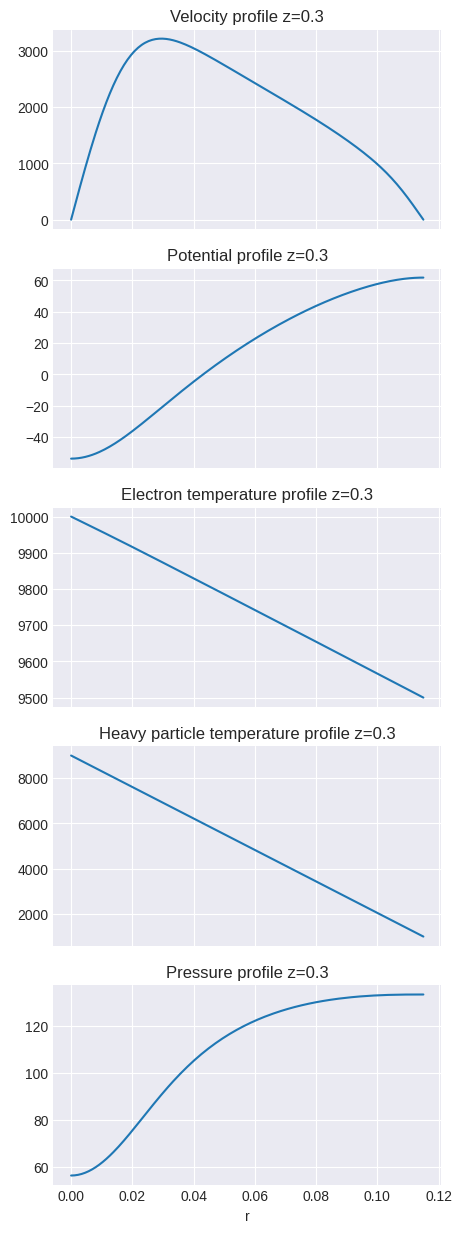

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(5, 15), sharex=True)
axs[0].plot(mesh_1d.geometry.x[:, 1], velocity_1d.x.array)
axs[0].set_title(f"Velocity profile z={pressure_profile_loc}")
axs[1].plot(mesh_1d.geometry.x[:, 1], potential_1d.x.array)
axs[1].set_title(f"Potential profile z={pressure_profile_loc}")
axs[2].plot(mesh_1d.geometry.x[:, 1], temperature_e_1d.x.array)
axs[2].set_title(f"Electron temperature profile z={pressure_profile_loc}")
axs[3].plot(mesh_1d.geometry.x[:, 1], temperature_h_1d.x.array)
axs[3].set_title(f"Heavy particle temperature profile z={pressure_profile_loc}")
axs[4].set_title(f"Pressure profile z={pressure_profile_loc}")
axs[4].plot(mesh_1d.geometry.x[:, 1], p.x.array)
axs[4].set_xlabel("r")
plt.show()